image.shape = (1011, 1011)
duration = 0.6739721298217773 s


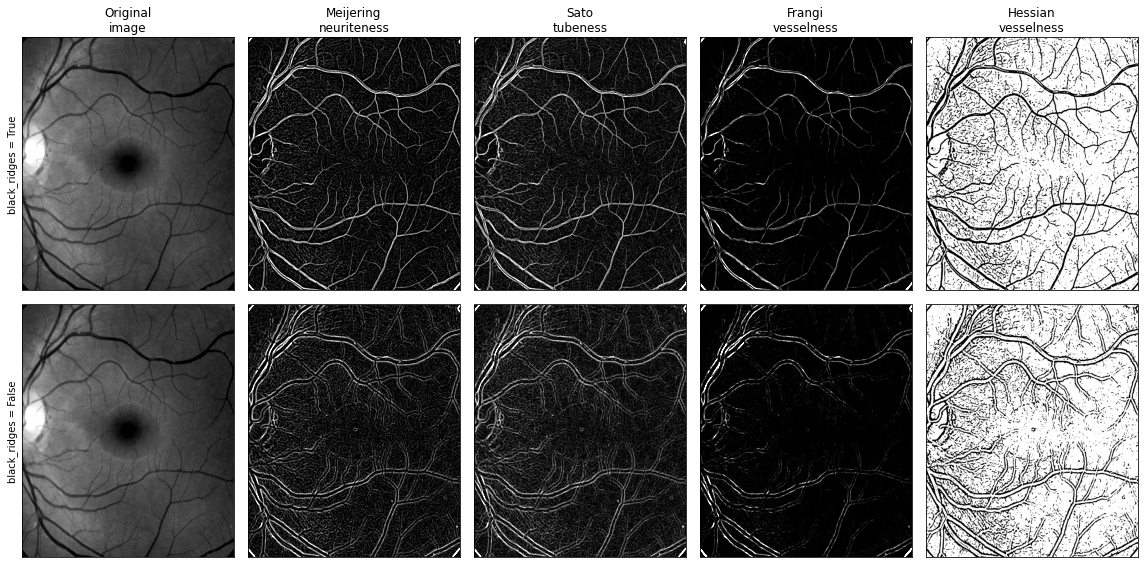

In [70]:
from time import time

import numpy as np

from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt


def identity(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image

retina = data.retina()[200:-200, 200:-200]

image = color.rgb2gray(retina)
image = image.astype(np.float32)
# image = np.tile(image, (4, 4))  # tile to increase size to roughly (4000, 4000)
print(f"image.shape = {image.shape}")

kwargs = {'sigmas': [2], 'mode': 'reflect'}
fig, axes = plt.subplots(2, 5, figsize=[16, 8])
cmap = plt.cm.gray
tstart = time()
for i, black_ridges in enumerate([1, 0]):
    for j, func in enumerate([identity, meijering, sato, frangi, hessian]):
        kwargs['black_ridges'] = black_ridges
        
        result = func(image, **kwargs)
        vmin, vmax = np.percentile(result, q=[1, 99.5])
        axes[i, j].imshow(result, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
        if i == 0:
            axes[i, j].set_title(['Original\nimage', 'Meijering\nneuriteness',
                                  'Sato\ntubeness', 'Frangi\nvesselness',
                                  'Hessian\nvesselness'][j])
        if j == 0:
            axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
print(f"duration = {time() - tstart} s")
plt.tight_layout()
plt.show()

image.shape = (1011, 1011)
duration = 0.6661205291748047 s


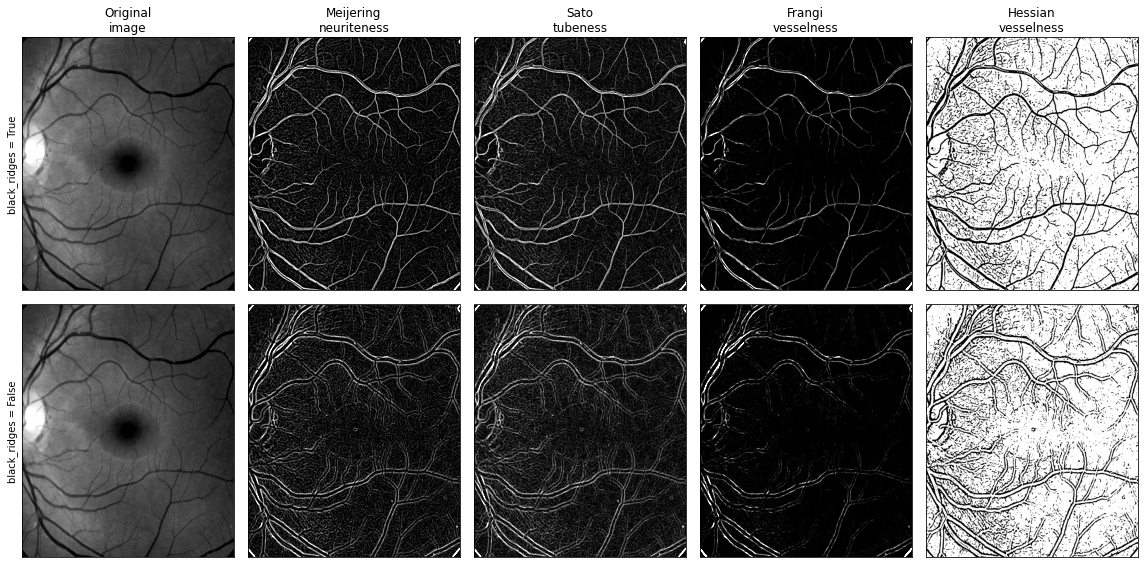

image.shape = (1011, 1011)
duration = 0.1250770092010498 s


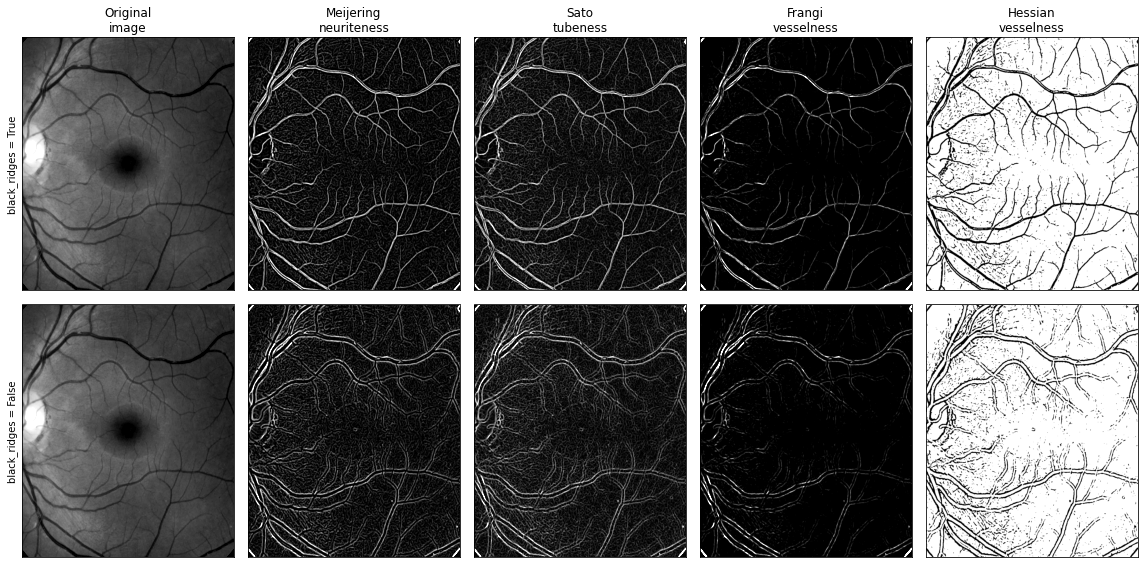

GPU Acceleration = 5.3257


In [74]:
from time import time

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

from skimage import data

durations = {}
for use_gpu in (False, True):
    
    if use_gpu:
        from cucim.skimage import color
        from cucim.skimage.filters import meijering, sato, frangi, hessian
        xp = cp
        asnumpy = cp.asnumpy
        device_name = "gpu"
    else:
        from skimage import color
        from skimage.filters import meijering, sato, frangi, hessian
        xp = np
        asnumpy = np.asarray
        device_name = "cpu"

    def identity(image, **kwargs):
        """Return the original image, ignoring any kwargs."""
        return image

    retina = data.retina()[200:-200, 200:-200]

    # transfer image to the GPU
    retina = xp.asarray(retina)

    image = color.rgb2gray(retina)
    image = image.astype(np.float32)
    # image = cp.tile(image, (4, 4))  # tile to increase size to roughly (4000, 4000)
    print(f"image.shape = {image.shape}")

    cmap = plt.cm.gray

    kwargs = {'sigmas': [2], 'mode': 'reflect'}
    fig, axes = plt.subplots(2, 5, figsize=[16, 8])

    tstart = time()
    for i, black_ridges in enumerate([1, 0]):
        for j, func in enumerate([identity, meijering, sato, frangi, hessian]):
            kwargs['black_ridges'] = black_ridges

            result = func(image, **kwargs)

            # transfer back to host for visualization with Matplotlib
            result_cpu = asnumpy(result)
            vmin, vmax = map(float, xp.percentile(result, q=[1, 99.5]))
            axes[i, j].imshow(result_cpu, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
            if i == 0:
                axes[i, j].set_title(['Original\nimage', 'Meijering\nneuriteness',
                                      'Sato\ntubeness', 'Frangi\nvesselness',
                                      'Hessian\nvesselness'][j])
            if j == 0:
                axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    dur = time() - tstart
    print(f"duration = {dur} s")
    durations[device_name] = dur
    plt.tight_layout()
    plt.show()

print(f"GPU Acceleration = {durations['cpu']/durations['gpu']:0.4f}")